In [1]:
import pandas as pd
import networkx as nx

/var/folders/lw/r6bk51ln09vdlk9nc13qh7280000gn/T/ipykernel_14036/3140611999.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


<h3>Graph Structure</h3>

<h4> Nodes </h4>

represent a product

Node features:
* *production* - quantifies product output considering sales orders, customer demand, vehicle fill rate, and delivery urgency.
* *sales order* - signifies distributor-requested quantities, pending approval from the accounts department.
* *delivered* - denotes products dispatched to distributors.
* *factory issue* - covers total products with issues shipped from manufacturing facilities, with some going to distributors and the rest to storage warehouses.



<h4> Edges </h4>

represent relations between products

Edge features:
* *GroupCode* :         1 or 0, if products are in the same product group
* *SubGroupCode* :      1 or 0, if products are in the same product sub-group
* *Plant* :             Number of plants in common
* *Storage Location* :  Number of Storage Locations in common

In [2]:
G = nx.Graph()

In [3]:
nodes = pd.read_csv('Raw Dataset/Homogenoeus/Nodes/Node Types (Product Group and Subgroup).csv')

nodes.head()

,Node,Group,Sub-Group
0,SOS008L02P,S,SOS
1,SOS005L04P,S,SOS
2,SOS003L04P,S,SOS
3,SOS002L09P,S,SOS
4,SOS001L12P,S,SOS


In [4]:
G.add_nodes_from(nodes['Node'])

In [5]:
def add_group_edges(path):
    """adds edges and edge features for groupcode and subgroupcode""" 
    df = pd.read_csv(path)
    edge_type = [col for col in df.columns if col[:4] != 'node'][0]
    md = [{edge_type:1} for product in df[edge_type]]
    G.add_edges_from(zip(df['node1'],df['node2'],md))

In [6]:
def add_other_edges(path):
    """adds edges and edge features for Plants and Storage Locations"""
    df = pd.read_csv(path)
    edge_type = [col for col in df.columns if col[:4] != 'node'][0]
    node1 = df['node1'].to_list()
    node2 = df['node2'].to_list()
    pairs = [set(t) for t in zip(node1,node2)]
    distinct_pairs = []
    pair_counts = []

    while len(pairs) > 0:
        p = pairs[0]
        distinct_pairs.append(p)
        n = pairs.count(p)
        pair_counts.append(n)

        for i in range(n):
            pairs.remove(p)
    
    edges = [tuple(s) + ({edge_type:pair_counts[i]},) for i,s in enumerate(distinct_pairs)]
    G.add_edges_from(edges)



In [7]:
add_other_edges('Raw Dataset/Homogenoeus/Edges/Edges (Plant).csv')
add_group_edges('Raw Dataset/Homogenoeus/Edges/Edges (Product Group).csv')
add_group_edges('Raw Dataset/Homogenoeus/Edges/Edges (Product Sub-Group).csv')
add_other_edges('Raw Dataset/Homogenoeus/Edges/Edges (Storage Location).csv')

In [8]:
#fill in attributes on edges where its missing

for node1, node2 in G.edges:
    edge_keys = G[node1][node2].keys()
    for edge_type in ['Plant','GroupCode','SubGroupCode','Storage Location']:
        if not edge_type in edge_keys:
            G[node1][node2][edge_type] = 0


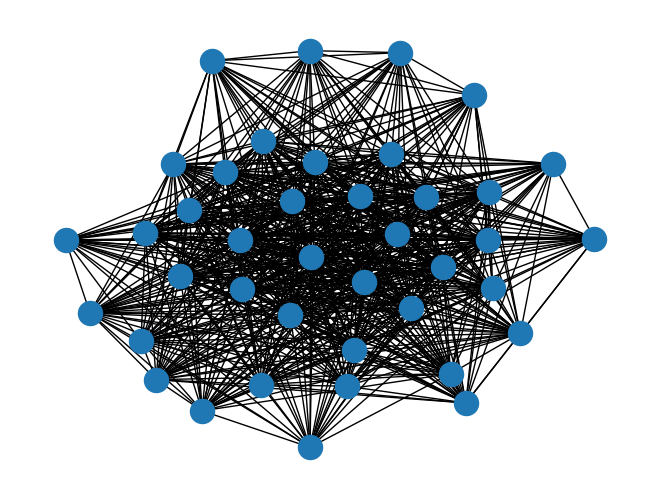

In [9]:
nx.draw(G)

In [10]:
d2d = pd.read_csv('Raw Dataset/Homogenoeus/Temporal Data/Weight/Delivery To distributor.csv')
factory_issue = pd.read_csv('Raw Dataset/Homogenoeus/Temporal Data/Weight/Factory Issue.csv')
production = pd.read_csv('Raw Dataset/Homogenoeus/Temporal Data/Weight/Production .csv')
sales_orders = pd.read_csv('Raw Dataset/Homogenoeus/Temporal Data/Weight/Sales Order .csv')

In [11]:
sales_orders.tail()

,Date,SOS008L02P,SOS005L04P,SOS003L04P,SOS002L09P,SOS001L12P,SOS500M24P,SOS250M48P,SOP001L12P,POV005L04P,...,MAHS025K,SE500G24P,SE200G24P,ATPPCH5X5K,ATPA1K24P,MAPA1K24P,MAP1K25P,MAC1K25P,EEA500G12P,EEA200G24P
216,2023-08-05 00:00:00,0.22080,19.3062,1.12608,6.40872,5.321280,1.20336,0.00000,0.08832,3.003,...,0.000,0.498000,0.000,0.0,0.0,0.0,0.00,0.0,0.0,0.0
217,2023-08-06 00:00:00,19.44512,137.4112,12.59664,83.56176,74.144640,31.98288,5.11152,0.33120,7.917,...,1.025,8.442000,0.576,0.0,0.0,0.0,0.00,0.0,0.0,0.0
218,2023-08-07 00:00:00,3.38560,95.1648,6.17136,61.20576,171.995804,26.33040,5.15568,0.33120,6.461,...,0.000,4.800498,0.120,0.0,0.0,0.0,0.24,0.0,0.0,0.0
219,2023-08-08 00:00:00,0.00000,0.0000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000,...,0.000,0.000000,0.000,0.0,0.0,0.0,0.00,0.0,0.0,0.0
220,2023-08-09 00:00:00,0.00000,0.0000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000,...,0.000,0.000000,0.000,0.0,0.0,0.0,0.00,0.0,0.0,0.0


noticed a lot of zeros so I'm going to check on the proportion of zeros for all the products

In [12]:
temporal = [d2d,factory_issue,production,sales_orders]
names = ['delivery','factory issue','production','sales']
inspect = {

}

for i,feat in enumerate(temporal):
    zeros = [len(feat[feat[col] == 0])/len(feat) for col in nodes['Node']]
    inspect[names[i]] = zeros

In [13]:
pd.DataFrame(inspect,index=nodes['Node'])

,delivery,factory issue,production,sales
Node,,,,
SOS008L02P,0.040724,0.126697,0.742081,0.217195
SOS005L04P,0.036199,0.072398,0.167421,0.176471
SOS003L04P,0.036199,0.076923,0.565611,0.194570
SOS002L09P,0.036199,0.085973,0.226244,0.171946
SOS001L12P,0.036199,0.076923,0.144796,0.185520
SOS500M24P,0.036199,0.076923,0.208145,0.194570
SOS250M48P,0.149321,0.371041,0.864253,0.253394
SOP001L12P,0.185520,0.411765,0.719457,0.294118
POV005L04P,0.036199,1.000000,0.561086,0.203620


I removed 12 products as they had almost all zero values  

In [14]:
G.remove_nodes_from(['EEA200G24P','EEA500G12P','MAC1K25P','MAP1K25P','MAPA1K24P','ATPA1K24P','ATPPCH5X5K','POP015K',
                     'SO0005L04P','SO0002L09P',	'SO0001L12P','SO0500M24P'])

In [15]:
#adding temporal data as node features

for node in G.nodes: 
    G.nodes[node]['delivered'] = d2d[node].to_numpy()
    G.nodes[node]['factory issue'] = factory_issue[node].to_numpy()
    G.nodes[node]['sales_order'] = sales_orders[node].to_numpy()
    G.nodes[node]['production'] = production[node].to_numpy()
    G.nodes[node]['GroupCode'] = nodes[nodes['Node'] == node]['Group'].iloc[0] #feature added for exploratory purposes

In [16]:
len(G.nodes)

28

In [17]:
len(G.edges)

374

In [18]:
import pickle

pickle.dump(G,open('graphs/graph.pkl','wb')) #Collab and collab pro
                                             #